<a href="https://colab.research.google.com/github/milindz/Food-Items-Classification/blob/main/Food_Classification(3).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Wed Dec  1 14:02:28 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P8    32W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### In this third notebook of this project series, I will be covering  Transfer Learning with Tensorflow - Fine Tuning.

> In fine-tuning transfer learning the pre-trained model weights from another model are unfrozen and tweaked during training to better suit your own data.

> For feature extraction transfer learning, you may only train the top 1-3 layers of a pre-trained model with your own data, in fine-tuning transfer learning, you might train 1-3 + layers of a pre-trained model (where the '+' indicates that many or all of the layers could be trained).

Steps to follow:
1. Build transfer learning model using keras Functional API.
2. A fine-tuned transfer learning model on 10% of the data
3. A fine-tuned transfer learning model on full data
4. Introduce the ModelCheckpoint callback to save training results


In [4]:
# Get 10% of the data of the 10 classes
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip 

# Unzip the downloaded file
import zipfile
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip", "r")
zip_ref.extractall()
zip_ref.close()

--2021-12-01 13:57:48--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.70.128, 74.125.202.128, 74.125.69.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.70.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.2’

10_food_classes_10_ 100%[===================>] 160.74M   183MB/s    in 0.9s    

2021-12-01 13:57:49 (183 MB/s) - ‘10_food_classes_10_percent.zip.2’ saved [168546183/168546183]



In [2]:
# Checking the image files in each folder
import os
for  dirpath,dirnames,filenames in os.walk("/content/10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)}files in {dirpath}")

There are 2 directories and 0files in /content/10_food_classes_10_percent
There are 10 directories and 0files in /content/10_food_classes_10_percent/train
There are 0 directories and 75files in /content/10_food_classes_10_percent/train/grilled_salmon
There are 0 directories and 75files in /content/10_food_classes_10_percent/train/hamburger
There are 0 directories and 75files in /content/10_food_classes_10_percent/train/steak
There are 0 directories and 75files in /content/10_food_classes_10_percent/train/sushi
There are 0 directories and 75files in /content/10_food_classes_10_percent/train/fried_rice
There are 0 directories and 75files in /content/10_food_classes_10_percent/train/chicken_curry
There are 0 directories and 75files in /content/10_food_classes_10_percent/train/ice_cream
There are 0 directories and 75files in /content/10_food_classes_10_percent/train/chicken_wings
There are 0 directories and 75files in /content/10_food_classes_10_percent/train/ramen
There are 0 directories 

In [3]:
import tensorflow as tf

We use tf.keras.prepreprocessing.image_dataset_from_directory() rather than ImageDataGenerator because it creates a tf.data.Dataset object rather than a generator. The main advantage of this is the tf.data.Datasetis much more efficient (faster) than the ImageDataGenerator.

In [4]:
# Data Preprocessing using ImageDataGenerator class


train_dir = "/content/10_food_classes_10_percent/train/"
test_dir = "/content/10_food_classes_10_percent/test/"


IMG_SIZE = (224,224)

train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical", 
                                                                            batch_size=32)
test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                           image_size=IMG_SIZE,
                                                                           label_mode="categorical")

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [5]:
train_data_10_percent

<BatchDataset shapes: ((None, 224, 224, 3), (None, 10)), types: (tf.float32, tf.float32)>

In [6]:
# class names
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [7]:
# Viweing sample batch of data
for images,labels in train_data_10_percent.take(10):
  print(images,labels)

tf.Tensor(
[[[[5.24693871e+01 2.21836739e+01 1.83673477e+01]
   [5.18367348e+01 2.41479588e+01 1.82193871e+01]
   [5.26989784e+01 2.71938763e+01 2.04234695e+01]
   ...
   [7.52754745e+01 4.12754784e+01 1.52856703e+01]
   [6.76478729e+01 3.36478691e+01 5.71928215e+00]
   [7.20867081e+01 3.88571167e+01 8.54590034e+00]]

  [[5.00714264e+01 2.20000000e+01 1.13061209e+01]
   [4.92040825e+01 2.31326523e+01 1.04183655e+01]
   [5.08724480e+01 2.71581650e+01 1.36581631e+01]
   ...
   [6.18010025e+01 3.16734524e+01 5.30098534e+00]
   [5.84285355e+01 2.83571072e+01 2.90779650e-01]
   [6.34540596e+01 3.43112030e+01 4.38263083e+00]]

  [[5.25765305e+01 2.82193871e+01 7.57652998e+00]
   [5.41734695e+01 2.91734695e+01 8.74489784e+00]
   [5.25765305e+01 2.94285736e+01 8.38265324e+00]
   ...
   [6.79948578e+01 4.26377258e+01 1.47805567e+01]
   [5.91988792e+01 3.46274490e+01 4.41316462e+00]
   [6.13775368e+01 3.82295685e+01 6.37242937e+00]]

  ...

  [[9.83468475e+01 6.65611115e+01 7.69183197e+01]
   [1

In [14]:
#  Model0 - Building a transfer learning model using Keras Functional API
# Step1 - Using tf.keras.applications create baseline model
base_model =  tf.keras.applications.EfficientNetB0(include_top=False)
# Freeze  the base model
base_model.trainable = False
#Inputs
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")
x = base_model(inputs)


# GlobalAveragePooling  transforms a 4D tensor into a 2D tensor by averaging the values across the inner-axes.
#It also condenses the information found by the base model into a lower dimension feature vector

x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
outputs =  tf.keras.layers.Dense(10,activation="softmax",name = "output_layer")(x)
model1 = tf.keras.Model(inputs,outputs)

#Compile the model
model1.compile(loss = "categorical_crossentropy",
               optimizer = tf.keras.optimizers.Adam(),
               metrics = ["accuracy"])

In [15]:
model1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


In [16]:
model1.history = model1.fit(train_data_10_percent,
                                 epochs=5,
                                 steps_per_epoch=len(train_data_10_percent),
                                 validation_data=test_data,
                                 validation_steps=int(0.25 * len(test_data))) 
                        

Epoch 1/5
24/24 [==============================] - 26s 371ms/step - loss: 1.8705 - accuracy: 0.3947 - val_loss: 1.3204 - val_accuracy: 0.7253
Epoch 2/5
24/24 [==============================] - 7s 265ms/step - loss: 1.1228 - accuracy: 0.7533 - val_loss: 0.8877 - val_accuracy: 0.8076
Epoch 3/5
24/24 [==============================] - 7s 264ms/step - loss: 0.8229 - accuracy: 0.8200 - val_loss: 0.7058 - val_accuracy: 0.8273
Epoch 4/5
24/24 [==============================] - 7s 265ms/step - loss: 0.6756 - accuracy: 0.8387 - val_loss: 0.6269 - val_accuracy: 0.8421
Epoch 5/5
24/24 [==============================] - 7s 266ms/step - loss: 0.5761 - accuracy: 0.8653 - val_loss: 0.5824 - val_accuracy: 0.8470


In [17]:
# Layers in base model
for layer_no, layer in enumerate(base_model.layers):
  print(layer_no,layer)

0 <keras.engine.input_layer.InputLayer object at 0x7f9410323310>
1 <keras.layers.preprocessing.image_preprocessing.Rescaling object at 0x7f9410fe3990>
2 <keras.layers.preprocessing.normalization.Normalization object at 0x7f9410fef390>
3 <keras.layers.convolutional.ZeroPadding2D object at 0x7f9410323d90>
4 <keras.layers.convolutional.Conv2D object at 0x7f94104c2910>
5 <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f9412e3fcd0>
6 <keras.layers.core.activation.Activation object at 0x7f9410fe6750>
7 <keras.layers.convolutional.DepthwiseConv2D object at 0x7f941033a690>
8 <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f9410335d90>
9 <keras.layers.core.activation.Activation object at 0x7f941076ba50>
10 <keras.layers.pooling.GlobalAveragePooling2D object at 0x7f9410345250>
11 <keras.layers.core.reshape.Reshape object at 0x7f941034add0>
12 <keras.layers.convolutional.Conv2D object at 0x7f94127a3d50>
13 <keras.layers.convolutional

In [18]:
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling_3 (Rescaling)        (None, None, None,   0           ['input_4[0][0]']                
                                3)                                                                
                                                                                                  
 normalization_3 (Normalization  (None, None, None,   7          ['rescaling_3[0][0]']            
 )                              3)                                                   

In [19]:
import matplotlib.pyplot as plt

# Plot the validation and training data separately
def plot_loss_curves(history):

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

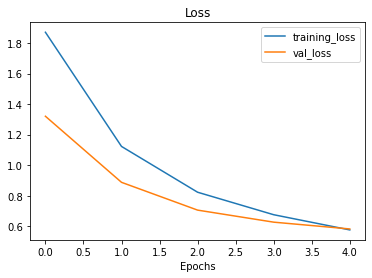

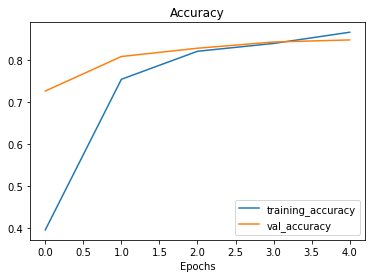

In [20]:
plot_loss_curves(model1.history)

In [24]:
# Creating a functional model with data augmentation and modelcheckpoint callback
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Data augmentation layer
data_augmentation = Sequential([
  preprocessing.RandomFlip('horizontal'),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2),
  preprocessing.RandomZoom(0.2),
  preprocessing.RandomRotation(0.2),              
], name="data_augmentation")

base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False
inputs = layers.Input(shape= (224,224,3), name="input_layer")
x = data_augmentation(inputs)
x = base_model(x, training= False)
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)
model2 = tf.keras.Model(inputs, outputs)

# Compile
model2.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), # use Adam optimizer with base learning rate
              metrics=["accuracy"])

In [25]:
# Creaitng ModelCheckpoint callback

In [27]:
model_checkpoint =  tf.keras.callbacks.ModelCheckpoint(filepath="model_checkpoint_wkts/checkpoint.cpt",
                                                       save_weights_only = True,
                                                       save_best_only  = False,
                                                       save_freq = "epoch",
                                                       verbose = 1)

In [29]:
model2_history =   model2.fit(train_data_10_percent,
                              epochs=5,
                              validation_data=test_data,
                              validation_steps=int(0.25 * len(test_data)),
                              callbacks=[ model_checkpoint])

Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 2.0381 - accuracy: 0.2893
Epoch 00001: saving model to model_checkpoint_wkts/checkpoint.cpt
24/24 [==============================] - 27s 804ms/step - loss: 2.0381 - accuracy: 0.2893 - val_loss: 1.4976 - val_accuracy: 0.6562
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.3912 - accuracy: 0.6640
Epoch 00002: saving model to model_checkpoint_wkts/checkpoint.cpt
24/24 [==============================] - 15s 607ms/step - loss: 1.3912 - accuracy: 0.6640 - val_loss: 1.0665 - val_accuracy: 0.7681
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 1.0851 - accuracy: 0.7267
Epoch 00003: saving model to model_checkpoint_wkts/checkpoint.cpt
24/24 [==============================] - 13s 528ms/step - loss: 1.0851 - accuracy: 0.7267 - val_loss: 0.8672 - val_accuracy: 0.7961
Epoch 4/5
24/24 [==============================] - ETA: 0s - loss: 0.9327 - accuracy: 0.7760
Epoch 00004: saving model to model

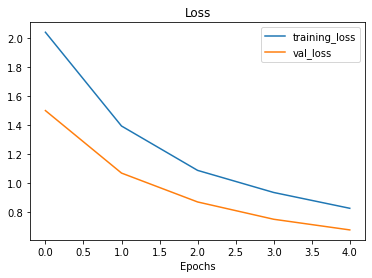

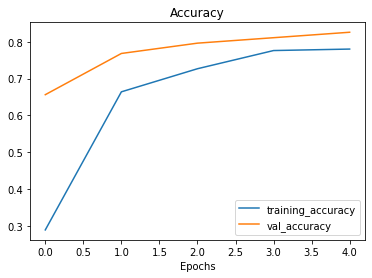

In [30]:
plot_loss_curves(model2_history)

In [31]:
# Loading saving weights and evaluating
model2.load_weights("model_checkpoint_wkts/checkpoint.cpt")
model_results =  model2.evaluate(test_data)

79/79 [==============================] - 11s 138ms/step - loss: 0.7040 - accuracy: 0.8116


In [32]:
# Model3 -  Fine-tuning an existing model on 10% of the data

In [33]:
model2.layers

In [34]:
for layer in model2.layers:
  print(layer.trainable)

True
True
False
True
True


In [35]:
model2.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

In [36]:
# Check if efficientb0 layer is trainable in model2 or not?
print(len(model2.layers[2].trainable_variables)) # index 2 is the EfficientNetB0 layer

0


Now to fine-tune the base model to our own data, we're going to unfreeze the top 10 layers and continue training our model for another 5 epochs.

In [37]:
base_model.trainable = True

# Freezing all the layers except for the last 10 layers
for layer in base_model.layers[:-10]:
  layer.trainable = False
  

In [42]:
# Recompile the model 
model2.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
              metrics=["accuracy"])

In [43]:
# let's check which layers of the pretrained model are trainable
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_7 False
1 rescaling_6 False
2 normalization_6 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [44]:
print(len(model2.layers[2].trainable_variables)) 

10


In [45]:
print(len(model2.trainable_variables)) 

12


In [48]:
model2_history.epoch[-1]

4

We're going to continue training on from where our previous model finished. Since it trained for 5 epochs, our fine-tuning will begin on the epoch 5 and continue for another 5 epochs

In [49]:
#Refitting the model
model2_updated_history =  model2.fit(train_data_10_percent,
                                     epochs =  10,
                                     validation_data = test_data,
                                     initial_epoch =  model2_history.epoch[-1],#start from previous last epoch
                                     validation_steps=int(0.25 * len(test_data)))

Epoch 5/10
24/24 [==============================] - 25s 676ms/step - loss: 0.6799 - accuracy: 0.8160 - val_loss: 0.5066 - val_accuracy: 0.8421
Epoch 6/10
24/24 [==============================] - 13s 522ms/step - loss: 0.5651 - accuracy: 0.8160 - val_loss: 0.5133 - val_accuracy: 0.8339
Epoch 7/10
24/24 [==============================] - 13s 515ms/step - loss: 0.4974 - accuracy: 0.8440 - val_loss: 0.4953 - val_accuracy: 0.8322
Epoch 8/10
24/24 [==============================] - 13s 524ms/step - loss: 0.4660 - accuracy: 0.8627 - val_loss: 0.4979 - val_accuracy: 0.8355
Epoch 9/10
24/24 [==============================] - 11s 459ms/step - loss: 0.4013 - accuracy: 0.8840 - val_loss: 0.4798 - val_accuracy: 0.8405
Epoch 10/10
24/24 [==============================] - 13s 509ms/step - loss: 0.3839 - accuracy: 0.8787 - val_loss: 0.4993 - val_accuracy: 0.8306


In [50]:
#Evaluating model
model2.evaluate(test_data)

79/79 [==============================] - 11s 131ms/step - loss: 0.5064 - accuracy: 0.8320


[0.5063633322715759, 0.8320000171661377]

In [51]:
# Model 4: Fine-tuning an existing model all of the data

In [53]:
# Download and unzip 10 classes of data with all images
import zipfile
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip 
zip_ref = zipfile.ZipFile("10_food_classes_all_data.zip", "r")
zip_ref.extractall()
zip_ref.close()

# Setup data directories
train_dir = "10_food_classes_all_data/train/"
test_dir = "10_food_classes_all_data/test/"

--2021-12-01 15:41:52--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.193.128, 173.194.194.128, 173.194.195.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.193.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip.1’

10_food_classes_all 100%[===================>] 495.13M   135MB/s    in 3.5s    

2021-12-01 15:41:55 (140 MB/s) - ‘10_food_classes_all_data.zip.1’ saved [519183241/519183241]



In [54]:
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_10_classes_full = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                 label_mode="categorical",
                                                                                 image_size=IMG_SIZE)

# Note: this is the same test dataset we've been using for the previous modelling experiments
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


As it is now, our model_2 has been fine-tuned on 10 percent of the data, so to begin fine-tuning on all of the data and keep our experiments consistent, we need to revert it back to the weights we checkpointed after 5 epochs of feature-extraction.

In [56]:
# Load model from checkpoint, that way we can fine-tune from the same stage the 10 percent data model was fine-tuned from
model2.load_weights("model_checkpoint_wkts/checkpoint.cpt")

In [57]:
model2.evaluate(test_data)

79/79 [==============================] - 11s 131ms/step - loss: 0.7040 - accuracy: 0.8116


[0.7039915919303894, 0.8116000294685364]

In [59]:
for layer_number, layer in enumerate(model2.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_layer True
1 data_augmentation True
2 efficientnetb0 True
3 global_average_pooling_layer True
4 output_layer True


In [60]:
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_7 False
1 rescaling_6 False
2 normalization_6 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [63]:
# Compile
model2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # divide learning rate by 10 for fine-tuning
                metrics=["accuracy"])

In [64]:
model2_history_full_data = model2.fit(train_data_10_classes_full,
                                           epochs= 10,
                                           initial_epoch= model2_history.epoch[-1],
                                           validation_data=test_data,
                                           validation_steps=int(0.25 * len(test_data)))

Epoch 5/10
235/235 [==============================] - 92s 355ms/step - loss: 0.7390 - accuracy: 0.7648 - val_loss: 0.3688 - val_accuracy: 0.8816
Epoch 6/10
235/235 [==============================] - 72s 305ms/step - loss: 0.5952 - accuracy: 0.8080 - val_loss: 0.3282 - val_accuracy: 0.9013
Epoch 7/10
235/235 [==============================] - 69s 289ms/step - loss: 0.5393 - accuracy: 0.8231 - val_loss: 0.2918 - val_accuracy: 0.9030
Epoch 8/10
235/235 [==============================] - 64s 272ms/step - loss: 0.4851 - accuracy: 0.8415 - val_loss: 0.2953 - val_accuracy: 0.9013
Epoch 9/10
235/235 [==============================] - 63s 266ms/step - loss: 0.4519 - accuracy: 0.8533 - val_loss: 0.2794 - val_accuracy: 0.9062
Epoch 10/10
235/235 [==============================] - 59s 250ms/step - loss: 0.4260 - accuracy: 0.8628 - val_loss: 0.2576 - val_accuracy: 0.9227


In [65]:
# Evaluate model on test_data
model2.evaluate(test_data)

79/79 [==============================] - 11s 129ms/step - loss: 0.3216 - accuracy: 0.8920


[0.32155540585517883, 0.8920000195503235]

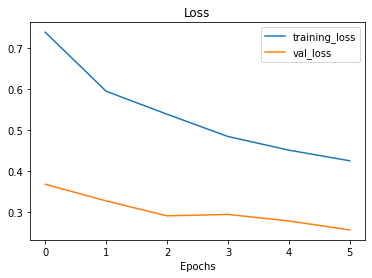

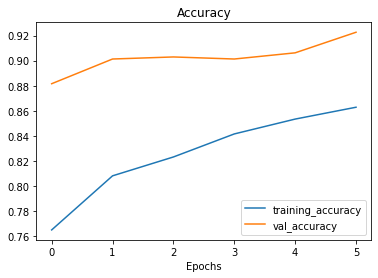

In [66]:
plot_loss_curves(model2_history_full_data)